In [15]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

sys.path.append('..')
from backend.DB.db import Database

In [3]:
db = Database()

### Aggregation of review sentiments by topic

In [4]:
sql = '''
SELECT topic_name, 
       COUNT(review_id) as num_reviews,
       AVG(sentiment) as mean_sentiment,
       MAX(sentiment) as max_sentiment,
       MIN(sentiment) as min_sentiment,
       SUM(angry) as count_angry 
FROM cooked_reviews
WHERE relevant = true
GROUP BY topic_name
ORDER BY mean_sentiment ASC
'''

results = db.query_sql(sql)
result_set = [{'topic': row[0], 
               'num_reviews': row[1],
               'avg_sentiment': row[2],
               'max_sentiment': row[3],
               'min_sentiment': row[4],
               'angry_guests': row[5]} for row in results]
results_df = pd.DataFrame(result_set)
results_df

,topic,num_reviews,avg_sentiment,max_sentiment,min_sentiment,angry_guests
0,housekeeping,20,3.400000,5,0,3
1,hotel condition,25,3.840000,5,1,1
2,value,28,3.857143,5,1,1
3,amenities,28,3.892857,5,1,0
4,frontdesk service,24,4.083333,5,1,2


How many are angry under each topic?

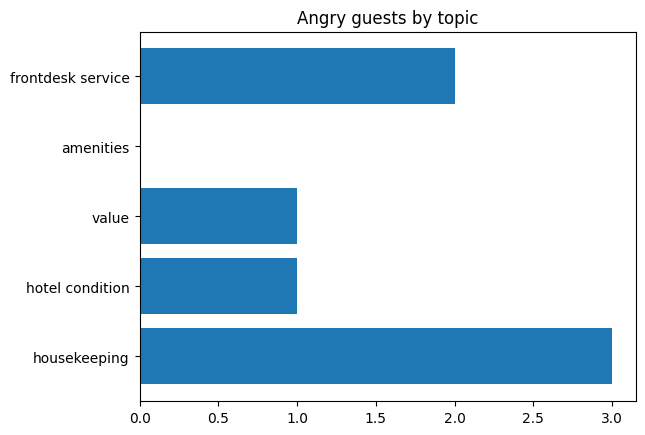

In [5]:
plt.barh(results_df['topic'], results_df['angry_guests'])
plt.title('Angry guests by topic')
plt.show()

### Distribution of sentiments for each topic

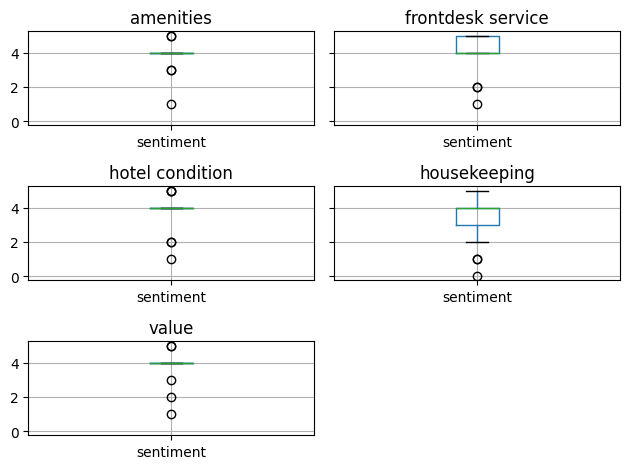

In [33]:
sql = '''
SELECT topic_name, sentiment
FROM cooked_reviews
WHERE relevant = true
ORDER BY topic_name;
'''

results = db.query_sql(sql)
data = [{'topic': t, 'sentiment': s} for t, s in results]
sentiments_df = pd.DataFrame(data)

sentiments_grouped = sentiments_df.groupby(by='topic')
sentiments_grouped.boxplot()
plt.tight_layout()
plt.title("Sentiment by topic")
plt.show()

### Angry Guests

Look at categorized reviews flagged as guest being angry from sentiment analysis by GPT

In [28]:
sql = '''
SELECT l.location_description, cr.source_name, cr.review_id, cr.topic_name, cr.sentiment, cr.summary
FROM cooked_reviews AS cr
JOIN locations as l
ON cr.source_name = l.source_name AND  cr.locations_location = l.locations_location
WHERE cr.angry > 0;
'''

results = db.query_sql(sql)
result_set = [{'place': row[0], 
               'review_source': row[1],
               'review_id': row[2],
            'topic': row[3],
            'sentiment': row[4],
            'summary': row[5]} for row in results]
results_df = pd.DataFrame(result_set)

sents = ['N/A', 'very bad', 'bad', 'neutral', 'good', 'very good']
results_df['sentiment'] = results_df['sentiment'].apply(lambda x: sents[x])
results_df

,place,review_source,review_id,topic,sentiment,summary
0,Hotel Moab Downtown,tripadvisor,862481775,housekeeping,very bad,The guest had to clean the room when they got ...
1,Hampton Inn,tripadvisor,888445411,frontdesk service,bad,The hotel does not allow guests to select thei...
2,Hampton Inn,tripadvisor,888445411,housekeeping,bad,The breakfast trays were not refilled properly...
3,Hampton Inn,tripadvisor,886905031,frontdesk service,bad,The guest had a negative experience during che...
4,Hotel Moab Downtown,tripadvisor,841352567,hotel condition,very bad,The guest reported that the hotel was infested...
5,Hotel Moab Downtown,tripadvisor,841352567,housekeeping,very bad,The guest did not mention anything about house...
6,Hotel Moab Downtown,tripadvisor,841352567,value,very bad,The guest would not recommend this place even ...


Make it into a sort of report

In [32]:
for index, data in results_df.iterrows():
    print(f'Place: {data["place"]}\nTopic: {data["topic"]}\nSentiment: {data["sentiment"]}')
    print(f'Source: {data["review_source"]}\nReview_ID: {data["review_id"]}')
    print('Summary:')
    pprint(data["summary"])
    print('================================\n')
    


Place: Hotel Moab Downtown
Topic: housekeeping
Sentiment: very bad
Source: tripadvisor
Review_ID: 862481775
Summary:
('The guest had to clean the room when they got there. The remote was dirty '
 'and sticky. Nightstand and desk have not been cleaned with cleaners in a '
 'while. Janitorial took this rating down. The guest should not have to go to '
 'city market on vacation and buy cleaning sprays to stay in a room.')

Place: Hampton Inn
Topic: frontdesk service
Sentiment: bad
Source: tripadvisor
Review_ID: 888445411
Summary:
('The hotel does not allow guests to select their own room and collects the '
 'resort fee at the front desk, causing inconvenience.')

Place: Hampton Inn
Topic: housekeeping
Sentiment: bad
Source: tripadvisor
Review_ID: 888445411
Summary:
('The breakfast trays were not refilled properly and guests were not informed '
 'that food would stop being served before the end of breakfast.')

Place: Hampton Inn
Topic: frontdesk service
Sentiment: bad
Source: tripadvisor


In [37]:
sql = '''
SELECT title, review_text, rating FROM raw_reviews
WHERE review_id = 862481775 AND source_name = "tripadvisor";
'''

results = list(db.query_sql(sql))
print(f'{results[0][0]} -- Guest Rating {results[0][2]} stars')
pprint(results[0][1])

Okay place to stay -- Guest Rating 3 stars
('Our stay was okay, check in was good but I am not sure all rooms have been '
 'upgraded, ours may have been half done. Shower was good, seemed like it had '
 'a new insert and shower heads. Carpet was worn, beds fine. Fridge did not '
 'get very cold although it was turned up all the way. Why a three star, we '
 'had to clean the room when we got there.  The remote was dirty and sticky. '
 'Night stand and desk have not been cleaned with cleaners in a while. I '
 'should not have to go to city market on vacation and by cleaning sprays to '
 'stay in a room. Janitorial took this rating down. Also the blinds had to be '
 'lined up to block out the residents in the back of our room. Get better '
 'window coverings.')
